In [27]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

### Проверим гипотезу о пороге перколяции и диаметре графа.

Пусть мы имеем граф Эрдеша-Реньи с N вершинами и вероятностью связи p. Диаметр графа $d = N * p$. 
Верно ли, что порог перколяции $\alpha$ ~ $\frac{1}{d}$?

1.Создадим 10 графов с разным числом вершин (от 500 до 5000)

In [14]:
N_arr = np.arange(500, 5001, 500)
p = 0.05
G_arr = [nx.erdos_renyi_graph(N, p) for N in N_arr]

In [16]:
nx.number_of_nodes(G_arr[9])

5000

2.Посчитаем порог перколяции для каждого графа

In [29]:
def getInfectedFractionModel2(G, numberSteps, thresholdInf, startNode):    
    inf = []
    susc = []
    
    inf_dict = defaultdict(list)
    
    cur_infected_node = startNode
    
    for i in range(numberSteps):
        
        #заражаем здоровую вершину
        if cur_infected_node not in inf:
            inf.append(cur_infected_node)
        
        #выбираем всех неактивных соседей этой вершины
        not_infected_neighbors = []
        for j in list(nx.all_neighbors(G, cur_infected_node)):
            if j not in inf:
                not_infected_neighbors.append(j)
    
        #если у вершины нет здоровых соседей, завершаем заражение
        if not not_infected_neighbors:
            print("Exit")
            break
            
        if not_infected_neighbors:
            for elem in not_infected_neighbors:
                p = random.uniform(0, 1)
                if p < thresholdInf:
                    inf_dict[i].append(elem)
            
        #добавим в список зараженных новые вершины
        for j in inf_dict[i]:
            inf.append(j)
        
        if inf_dict[i]:
            inf.remove(cur_infected_node)
            cur_infected_node = random.choice(inf_dict[i])
            
    return inf

In [67]:
infection_array = []
prob_model2 = np.arange(0.00001, 0.1, 0.01)
for i in range(10):
    startNode = random.randint(1, nx.number_of_nodes(G_arr[i]))
    inf_arr_model2 = []
    for p in prob_model2:
        infected_arr = getInfectedFractionModel2(G_arr[i], 1000, p, startNode)
        inf_arr_model2.append(len(infected_arr) / nx.number_of_nodes(G_arr[i]))
    infection_array.append(inf_arr_model2)

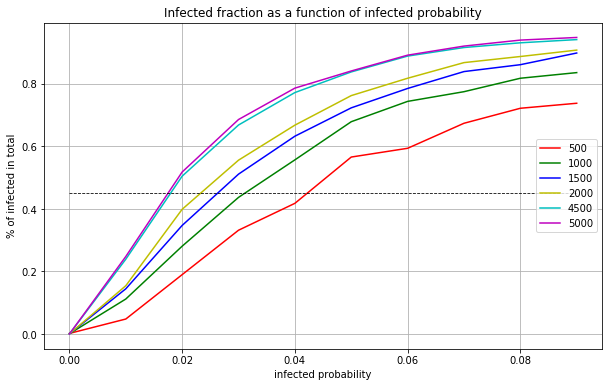

In [78]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(prob_model2, infection_array[0], 'r', linewidth=1.5, label='500')

ax.plot(prob_model2, infection_array[1], 'g', linewidth=1.5, label='1000')

ax.plot(prob_model2, infection_array[2], 'b', linewidth=1.5, label='1500')

ax.plot(prob_model2, infection_array[3], 'y', linewidth=1.5, label='2000')

ax.plot(prob_model2, infection_array[8], 'c', linewidth=1.5, label='4500')

ax.plot(prob_model2, infection_array[9], 'm', linewidth=1.5, label='5000')

ax.plot(prob_model2, np.full((len(prob_model2), 1), 0.45), 'k--', linewidth=0.8)

ax.grid(True)
ax.legend(loc='right')
ax.set_title('Infected fraction as a function of infected probability')
ax.set_xlabel('infected probability')
ax.set_ylabel('% of infected in total')

plt.show()